# Exersice 4

#### Sepideh Ghaemifar 2072829, Ehsan Eslami Shafigh 2070769, Abbas Zal 2072054, Poornima Amali Wickramasinghe 2088370

## The Main Code

### Importing Libraries

In [58]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow.random as tf_r

### Data Generation

In [319]:
np.random.seed(123)

CASE = 1

S = 2
N = 1000
N_train = int(N/2)
N_test  = N - N_train
x = S*(2*np.random.rand(N,2)-1)
y = np.zeros(N).astype(int)

for n in range(N):
    if CASE==1:
        if x[n,1]<-0.6 and x[n,0]>-0.2: y[n]=1
        if x[n,1]>0.4 and x[n,0]<-0.8: y[n]=1
        if x[n,1]>1.0 and x[n,0]>0.8: y[n]=1
    elif CASE==2:
        if x[n,1]<0 and x[n,0]>0.5: y[n]=1
        if x[n,1]>0 and np.sqrt((x[n,0]+0.3)**2+x[n,1]**2)<1.5: y[n]=1

x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

### Plot the Dataset

[ 0.78587674 -0.85544266] 1
[-1.09259419  0.20525908] 0
[ 0.87787588 -0.30757416] 0
[1.92305679 0.73931895] 0
[-0.07627239 -0.43152993] 0


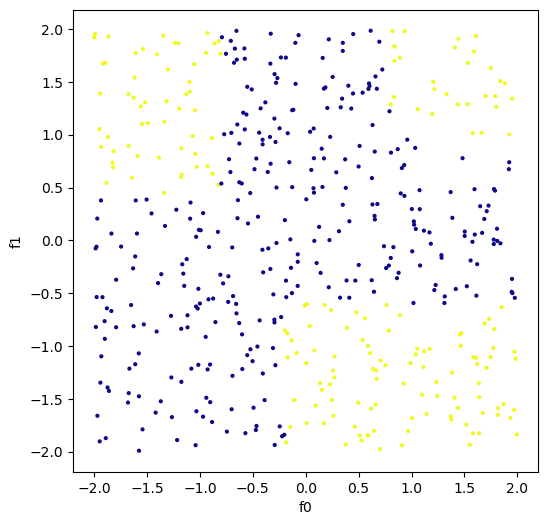

In [320]:
def scat(x,y,s=4,cmap="plasma"):
    plt.scatter(x[:,0],x[:,1],s=s,c=y,cmap=cmap)
    plt.xlabel("f0")
    plt.ylabel("f1")

for n in range(5):
    print(x[n],y[n])

plt.figure(figsize=(6,6))
scat(x_train,y_train)
#scat(x_test,y_test,cmap="winter",s=7)
plt.show()

In [172]:
def Rescale(x):
    #return (x-x.mean())/np.sqrt(x.var())
    return x/2

x_train = Rescale(x_train)
x_test = Rescale(x_test)

### DNN Model

In [173]:
np.random.seed(12345)
tf_r.set_seed(12345)

L = 2

def create_DNN(activation, n_hidden_layers):
    model = Sequential()
    model.add(Dense(L,input_shape=(L,),activation=activation))
    
    for i in range(n_hidden_layers):
        model.add(Dense(20,activation=activation))   # 20 cells in each hidden layer
    
    model.add(Dropout(0.01))
    model.add(Dense(1,activation='sigmoid'))
    nepoch=400
    
    return model


def model_compiler(optimizer ,activation, n_hidden_layers):
    model = create_DNN(activation, n_hidden_layers)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [174]:
DNN_model = model_compiler( 'Adamax','elu', 3 )

DNN_fit = DNN_model.fit(x_train, y_train,
               epochs = 400, batch_size = 50,
               validation_data=(x_test,y_test),
               verbose=0)

In [175]:
DNN_error = 1 - DNN_fit.history['val_accuracy'][-1]
DNN_error * 100

0.8571445941925049

### XGBoost

In [176]:
XGBoost_model = XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=10, n_estimators=70 , gamma = 0)

XGBoost_fit = XGBoost_model.fit(x_train, y_train)

In [177]:
XGBoost_error = 1 - XGBoost_model.score(x_test, y_test)
XGBoost_error * 100

0.08571428571428896

### Task 1

We use the main code above, to apply a DNN and XGBoost model on the same dataset. We vary the size of the dataset from 100 to 5000, to see how the error of the two models vary accordingly.

It is a matter of question, how to choose the parameters of the XGBoost and the DNN model. We decided to find the best model parameters for both of the models, when the smallest dataset is used for training (= 100). But for the rest of the datasets, we will keep the same parameters that we started with. 

So first we take the training data of size 100 and perform a grid search for both models:

For the DNN model, we do a grid search on the following parameters: the optimizer, the activation function, and number of layers.

In [6]:
# list of allowed optional arguments for the optimizer, see `compile_model()`
optimizer = ['SGD', 'Adam' , 'RMSprop', 'Adagrad', 'Adadelta', 'Adamax', 'Nadam']

# list of allowed optional arguments for the Activation Function
activation = ['relu', 'elu', 'tanh', 'sigmoid']

# List for Few deifferent number of hidden layers (otherwise the runnig time would get so much longer)
n_hidden_layers = [3,4]

# training parameters
batch_size = 64
epochs = 10

# GS estimator
model_gridsearch = KerasClassifier(
                        build_fn=model_compiler, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=1
                    )


param_grid = dict(optimizer = optimizer , activation = activation , n_hidden_layers = n_hidden_layers )

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4 , verbose = 4)  # Using 4_Cross_Validation
grid_result = grid.fit(x_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 4 folds for each of 56 candidates, totalling 224 fits
Epoch 1/10


C:\Users\PoD\AppData\Local\Temp\ipykernel_5624\439246911.py:15: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(


1/1 [==============================] - 1s 677ms/step - loss: 0.6879 - accuracy: 0.4865
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6871 - accuracy: 0.6757
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.7027
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.7027
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.7027
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6835 - accuracy: 0.7027
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6826 - accuracy: 0.7027
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6823 - accuracy: 0.7027
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.7027
Epoch 10/10
1/1 [==============================] - 0s 145ms/step - loss: 0.6730 - accuracy: 0.8462
[CV 1/4] END activation=relu, n_hidden_layers=

Epoch 1/10
1/1 [==============================] - 1s 840ms/step - loss: 0.6908 - accuracy: 0.7105
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6881 - accuracy: 0.7105
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.7368
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.7368
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.7368
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.7368
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6790 - accuracy: 0.7368
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6774 - accuracy: 0.7368
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6754 - accuracy: 0.7368
Epoch 10/10
1/1 [==============================] - 0s 111ms/step - loss: 0.6711 - accuracy: 0.7500
[CV 3/4] END activation=relu, n_hid

1/1 [==============================] - 0s 7ms/step - loss: 0.6825 - accuracy: 0.7568
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6815 - accuracy: 0.7568
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6817 - accuracy: 0.7568
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.7568
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6820 - accuracy: 0.7568
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6810 - accuracy: 0.7568
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6803 - accuracy: 0.7568
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.7568
Epoch 10/10
1/1 [==============================] - 0s 112ms/step - loss: 0.6832 - accuracy: 0.6923
[CV 2/4] END activation=relu, n_hidden_layers=3, optimizer=Adagrad;, score=0.692 total time=   0.7s
Epoch 1/10
1/1 [============================

1/1 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.7568
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.7027
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.7568
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6881 - accuracy: 0.7027
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6866 - accuracy: 0.7027
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.7027
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6847 - accuracy: 0.7027
Epoch 10/10
1/1 [==============================] - 0s 114ms/step - loss: 0.6751 - accuracy: 0.8462
[CV 1/4] END activation=relu, n_hidden_layers=3, optimizer=Adamax;, score=0.846 total time=   1.1s
Epoch 1/10
1/1 [==============================] - 1s 714ms/step - loss: 0.6922 - accuracy: 0.4324
Epoch 2/10
1/1 [===========================

1/1 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5263
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5526
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5789
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.6316
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.6842
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6844 - accuracy: 0.6842
Epoch 10/10
1/1 [==============================] - 0s 109ms/step - loss: 0.6955 - accuracy: 0.7500
[CV 4/4] END activation=relu, n_hidden_layers=3, optimizer=Nadam;, score=0.750 total time=   1.6s
Epoch 1/10
1/1 [==============================] - 1s 525ms/step - loss: 0.6912 - accuracy: 0.6757
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.7027
Epoch 3/10
1/1 [============================

1/1 [==============================] - 0s 4ms/step - loss: 0.6694 - accuracy: 0.7368
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6668 - accuracy: 0.7368
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6631 - accuracy: 0.7368
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6619 - accuracy: 0.7368
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6590 - accuracy: 0.7368
Epoch 10/10
1/1 [==============================] - 0s 115ms/step - loss: 0.6612 - accuracy: 0.7500
[CV 3/4] END activation=relu, n_hidden_layers=4, optimizer=Adam;, score=0.750 total time=   1.1s
Epoch 1/10
1/1 [==============================] - 1s 889ms/step - loss: 0.6907 - accuracy: 0.3947
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6878 - accuracy: 0.7632
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6850 - accuracy: 0.7632
Epoch 4/10
1/1 [=============================

1/1 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5676
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6924 - accuracy: 0.5946
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5676
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.6216
Epoch 10/10
1/1 [==============================] - 0s 119ms/step - loss: 0.6925 - accuracy: 0.5385
[CV 2/4] END activation=relu, n_hidden_layers=4, optimizer=Adagrad;, score=0.538 total time=   0.8s
Epoch 1/10
1/1 [==============================] - 1s 531ms/step - loss: 0.6989 - accuracy: 0.3421
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6987 - accuracy: 0.3158
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.3158
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6981 - accuracy: 0.3421
Epoch 5/10
1/1 [==========================

1/1 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.7027
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6868 - accuracy: 0.7027
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6847 - accuracy: 0.7027
Epoch 10/10
1/1 [==============================] - 0s 116ms/step - loss: 0.6707 - accuracy: 0.8462
[CV 1/4] END activation=relu, n_hidden_layers=4, optimizer=Adamax;, score=0.846 total time=   1.1s
Epoch 1/10
1/1 [==============================] - 1s 896ms/step - loss: 0.6863 - accuracy: 0.7568
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6847 - accuracy: 0.7297
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6823 - accuracy: 0.7568
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6805 - accuracy: 0.7568
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6788 - accuracy: 0.7568
Epoch 6/10
1/1 [===========================

1/1 [==============================] - 0s 8ms/step - loss: 0.6951 - accuracy: 0.5263
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.6053
Epoch 10/10
1/1 [==============================] - 0s 149ms/step - loss: 0.6936 - accuracy: 0.5833
[CV 4/4] END activation=relu, n_hidden_layers=4, optimizer=Nadam;, score=0.583 total time=   2.2s
Epoch 1/10
1/1 [==============================] - 1s 624ms/step - loss: 0.6946 - accuracy: 0.5676
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.5676
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5676
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.5946
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5946
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6830 - accuracy: 0.6216
Epoch 7/10
1/1 [============================

1/1 [==============================] - 0s 5ms/step - loss: 0.6411 - accuracy: 0.6842
Epoch 10/10
1/1 [==============================] - 0s 110ms/step - loss: 0.6716 - accuracy: 0.5000
[CV 3/4] END activation=elu, n_hidden_layers=3, optimizer=Adam;, score=0.500 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 783ms/step - loss: 0.6487 - accuracy: 0.5789
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6433 - accuracy: 0.6053
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6395 - accuracy: 0.6053
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6371 - accuracy: 0.6053
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6280 - accuracy: 0.6842
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6275 - accuracy: 0.6842
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6211 - accuracy: 0.7105
Epoch 8/10
1/1 [==============================

1/1 [==============================] - 0s 111ms/step - loss: 0.7162 - accuracy: 0.3846
[CV 2/4] END activation=elu, n_hidden_layers=3, optimizer=Adagrad;, score=0.385 total time=   0.9s
Epoch 1/10
1/1 [==============================] - 0s 491ms/step - loss: 0.7076 - accuracy: 0.4474
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7064 - accuracy: 0.4474
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7047 - accuracy: 0.4737
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.7037 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 0.7015 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.7022 - accuracy: 0.4737
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.7004 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.7026 - accuracy: 0.5000
Epoch 9/10
1/1 [============================

1/1 [==============================] - 0s 109ms/step - loss: 0.6463 - accuracy: 0.8462
[CV 1/4] END activation=elu, n_hidden_layers=3, optimizer=Adamax;, score=0.846 total time=   0.9s
Epoch 1/10
1/1 [==============================] - 1s 711ms/step - loss: 0.6990 - accuracy: 0.4054
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.4324
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6886 - accuracy: 0.4865
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.5405
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6767 - accuracy: 0.6486
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6671 - accuracy: 0.7568
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6672 - accuracy: 0.7568
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6614 - accuracy: 0.7568
Epoch 9/10
1/1 [=============================

Epoch 1/10
1/1 [==============================] - 1s 896ms/step - loss: 0.6895 - accuracy: 0.5405
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6855 - accuracy: 0.5405
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6835 - accuracy: 0.5405
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.5676
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6784 - accuracy: 0.6216
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6759 - accuracy: 0.6486
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6733 - accuracy: 0.6486
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6714 - accuracy: 0.6757
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6685 - accuracy: 0.7027
Epoch 10/10
1/1 [==============================] - 0s 145ms/step - loss: 0.6262 - accuracy: 0.8462
[CV 1/4] END activation=elu, n_hidd

1/1 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.7368
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6806 - accuracy: 0.7632
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6758 - accuracy: 0.7632
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6714 - accuracy: 0.7632
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6680 - accuracy: 0.7368
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6618 - accuracy: 0.7895
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6591 - accuracy: 0.7368
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6521 - accuracy: 0.7632
Epoch 10/10
1/1 [==============================] - 0s 118ms/step - loss: 0.6369 - accuracy: 0.7500
[CV 4/4] END activation=elu, n_hidden_layers=4, optimizer=Adam;, score=0.750 total time=   1.1s
Epoch 1/10
1/1 [==============================] 

1/1 [==============================] - 0s 5ms/step - loss: 0.6964 - accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6953 - accuracy: 0.5263
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.5263
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.5263
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5263
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5263
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.5000
Epoch 10/10
1/1 [==============================] - 0s 141ms/step - loss: 0.6739 - accuracy: 0.8333
[CV 3/4] END activation=elu, n_hidden_layers=4, optimizer=Adagrad;, score=0.833 total time=   0.9s
Epoch 1/10
1/1 [==============================] - 1s 667ms/step - loss: 0.6782 - accuracy: 0.5789
Epoch 2/10
1/1 [===========================

1/1 [==============================] - 0s 5ms/step - loss: 0.6738 - accuracy: 0.6757
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6694 - accuracy: 0.6757
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6649 - accuracy: 0.6757
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.7568
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6551 - accuracy: 0.7297
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6492 - accuracy: 0.7568
Epoch 10/10
1/1 [==============================] - 0s 120ms/step - loss: 0.6561 - accuracy: 0.6923
[CV 2/4] END activation=elu, n_hidden_layers=4, optimizer=Adamax;, score=0.692 total time=   1.1s
Epoch 1/10
1/1 [==============================] - 1s 801ms/step - loss: 0.7254 - accuracy: 0.3947
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 0.7170 - accuracy: 0.3947
Epoch 3/10
1/1 [============================

1/1 [==============================] - 0s 5ms/step - loss: 0.6851 - accuracy: 0.5676
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6761 - accuracy: 0.6757
Epoch 7/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6760 - accuracy: 0.6757
Epoch 8/10
1/1 [==============================] - 0s 9ms/step - loss: 0.6748 - accuracy: 0.6757
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6711 - accuracy: 0.6757
Epoch 10/10
1/1 [==============================] - 0s 112ms/step - loss: 0.6369 - accuracy: 0.8462
[CV 1/4] END activation=tanh, n_hidden_layers=3, optimizer=SGD;, score=0.846 total time=   0.7s
Epoch 1/10
1/1 [==============================] - 0s 489ms/step - loss: 0.6935 - accuracy: 0.4324
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.4595
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.5946
Epoch 4/10
1/1 [==============================

1/1 [==============================] - 0s 5ms/step - loss: 0.6620 - accuracy: 0.8421
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6527 - accuracy: 0.8947
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6442 - accuracy: 0.8684
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.8684
Epoch 10/10
1/1 [==============================] - 0s 110ms/step - loss: 0.6711 - accuracy: 0.6667
[CV 4/4] END activation=tanh, n_hidden_layers=3, optimizer=Adam;, score=0.667 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 575ms/step - loss: 0.6922 - accuracy: 0.5135
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6723 - accuracy: 0.5676
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6602 - accuracy: 0.6486
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6509 - accuracy: 0.7297
Epoch 5/10
1/1 [=============================

1/1 [==============================] - 0s 7ms/step - loss: 0.6781 - accuracy: 0.5789
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6796 - accuracy: 0.6053
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6791 - accuracy: 0.5789
Epoch 10/10
1/1 [==============================] - 0s 140ms/step - loss: 0.6642 - accuracy: 0.7500
[CV 3/4] END activation=tanh, n_hidden_layers=3, optimizer=Adagrad;, score=0.750 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 526ms/step - loss: 0.6869 - accuracy: 0.6053
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6839 - accuracy: 0.6053
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6814 - accuracy: 0.6316
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.6053
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6817 - accuracy: 0.6316
Epoch 6/10
1/1 [==========================

1/1 [==============================] - 0s 5ms/step - loss: 0.6552 - accuracy: 0.7568
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6467 - accuracy: 0.7838
Epoch 10/10
1/1 [==============================] - 0s 128ms/step - loss: 0.6524 - accuracy: 0.7692
[CV 2/4] END activation=tanh, n_hidden_layers=3, optimizer=Adamax;, score=0.769 total time=   1.2s
Epoch 1/10
1/1 [==============================] - 1s 983ms/step - loss: 0.7001 - accuracy: 0.3421
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6998 - accuracy: 0.4211
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.5789
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.6053
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6863 - accuracy: 0.5789
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.5789
Epoch 7/10
1/1 [===========================

1/1 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.5676
Epoch 10/10
1/1 [==============================] - 0s 115ms/step - loss: 0.6920 - accuracy: 0.4615
[CV 1/4] END activation=tanh, n_hidden_layers=4, optimizer=SGD;, score=0.462 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 542ms/step - loss: 0.6891 - accuracy: 0.4865
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6845 - accuracy: 0.4865
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6834 - accuracy: 0.4865
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6747 - accuracy: 0.5405
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6677 - accuracy: 0.5946
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6650 - accuracy: 0.6486
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6577 - accuracy: 0.6486
Epoch 8/10
1/1 [==============================

1/1 [==============================] - 0s 141ms/step - loss: 0.6674 - accuracy: 0.7500
[CV 4/4] END activation=tanh, n_hidden_layers=4, optimizer=Adam;, score=0.750 total time=   1.3s
Epoch 1/10
1/1 [==============================] - 1s 752ms/step - loss: 0.6691 - accuracy: 0.6216
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6510 - accuracy: 0.6486
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6425 - accuracy: 0.6757
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6375 - accuracy: 0.7027
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6307 - accuracy: 0.7027
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6234 - accuracy: 0.7297
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6208 - accuracy: 0.7568
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6079 - accuracy: 0.7568
Epoch 9/10
1/1 [==============================

1/1 [==============================] - 0s 139ms/step - loss: 0.6814 - accuracy: 0.7500
[CV 3/4] END activation=tanh, n_hidden_layers=4, optimizer=Adagrad;, score=0.750 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 664ms/step - loss: 0.7112 - accuracy: 0.4211
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7094 - accuracy: 0.4474
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7066 - accuracy: 0.4737
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7048 - accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7055 - accuracy: 0.4737
Epoch 6/10
1/1 [==============================] - 0s 8ms/step - loss: 0.7012 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6992 - accuracy: 0.5000
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6994 - accuracy: 0.5000
Epoch 9/10
1/1 [===========================

1/1 [==============================] - 1s 1s/step - loss: 0.7471 - accuracy: 0.4474
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7402 - accuracy: 0.4737
Epoch 3/10
1/1 [==============================] - 0s 8ms/step - loss: 0.7270 - accuracy: 0.4737
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7185 - accuracy: 0.4737
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7092 - accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6981 - accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6911 - accuracy: 0.5526
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6834 - accuracy: 0.5263
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6740 - accuracy: 0.5263
Epoch 10/10
1/1 [==============================] - 0s 158ms/step - loss: 0.6470 - accuracy: 0.7500
[CV 3/4] END activation=tanh, n_hidden_layers=4, 

1/1 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.6757
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6744 - accuracy: 0.7568
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6737 - accuracy: 0.7568
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6741 - accuracy: 0.6757
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6517 - accuracy: 0.7568
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6849 - accuracy: 0.6757
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6619 - accuracy: 0.7568
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6585 - accuracy: 0.7297
Epoch 10/10
1/1 [==============================] - 0s 112ms/step - loss: 0.6627 - accuracy: 0.6923
[CV 2/4] END activation=sigmoid, n_hidden_layers=3, optimizer=SGD;, score=0.692 total time=   0.7s
Epoch 1/10
1/1 [=============================

1/1 [==============================] - 0s 5ms/step - loss: 0.7430 - accuracy: 0.3243
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7378 - accuracy: 0.2703
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7344 - accuracy: 0.3243
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7120 - accuracy: 0.3243
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7130 - accuracy: 0.2703
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7053 - accuracy: 0.3784
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.7017 - accuracy: 0.2973
Epoch 10/10
1/1 [==============================] - 0s 134ms/step - loss: 0.6785 - accuracy: 0.8462
[CV 1/4] END activation=sigmoid, n_hidden_layers=3, optimizer=RMSprop;, score=0.846 total time=   0.9s
Epoch 1/10
1/1 [==============================] - 1s 690ms/step - loss: 0.5720 - accuracy: 0.7568
Epoch 2/10
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.6493 - accuracy: 0.7368
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6452 - accuracy: 0.7105
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6412 - accuracy: 0.7632
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6514 - accuracy: 0.7368
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6408 - accuracy: 0.7368
Epoch 9/10
1/1 [==============================] - 0s 5ms/step - loss: 0.6434 - accuracy: 0.7632
Epoch 10/10
1/1 [==============================] - 0s 129ms/step - loss: 0.6606 - accuracy: 0.6667
[CV 4/4] END activation=sigmoid, n_hidden_layers=3, optimizer=Adagrad;, score=0.667 total time=   1.1s
Epoch 1/10
1/1 [==============================] - 1s 831ms/step - loss: 0.6991 - accuracy: 0.6216
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6902 - accuracy: 0.6757
Epoch 3/10
1/1 [=======================

1/1 [==============================] - 0s 6ms/step - loss: 0.8024 - accuracy: 0.2632
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7962 - accuracy: 0.2632
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7874 - accuracy: 0.2632
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.7909 - accuracy: 0.2632
Epoch 9/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7861 - accuracy: 0.2632
Epoch 10/10
1/1 [==============================] - 0s 110ms/step - loss: 0.7659 - accuracy: 0.2500
[CV 3/4] END activation=sigmoid, n_hidden_layers=3, optimizer=Adamax;, score=0.250 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 713ms/step - loss: 1.0048 - accuracy: 0.2368
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.9833 - accuracy: 0.2368
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.9849 - accuracy: 0.2368
Epoch 4/10
1/1 [========================

1/1 [==============================] - 0s 7ms/step - loss: 0.8082 - accuracy: 0.2432
Epoch 7/10
1/1 [==============================] - 0s 8ms/step - loss: 0.8134 - accuracy: 0.2432
Epoch 8/10
1/1 [==============================] - 0s 6ms/step - loss: 0.8091 - accuracy: 0.2432
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7924 - accuracy: 0.2432
Epoch 10/10
1/1 [==============================] - 0s 150ms/step - loss: 0.7638 - accuracy: 0.3077
[CV 2/4] END activation=sigmoid, n_hidden_layers=4, optimizer=SGD;, score=0.308 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 658ms/step - loss: 0.6070 - accuracy: 0.7368
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6004 - accuracy: 0.7368
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.5926 - accuracy: 0.7368
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6056 - accuracy: 0.7368
Epoch 5/10
1/1 [===========================

1/1 [==============================] - 0s 9ms/step - loss: 0.6470 - accuracy: 0.7027
Epoch 8/10
1/1 [==============================] - 0s 10ms/step - loss: 0.6565 - accuracy: 0.6757
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6497 - accuracy: 0.6757
Epoch 10/10
1/1 [==============================] - 0s 134ms/step - loss: 0.5877 - accuracy: 0.8462
[CV 1/4] END activation=sigmoid, n_hidden_layers=4, optimizer=RMSprop;, score=0.846 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 680ms/step - loss: 0.6022 - accuracy: 0.7568
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: 0.5978 - accuracy: 0.7568
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.5821 - accuracy: 0.7568
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 0.5767 - accuracy: 0.7568
Epoch 5/10
1/1 [==============================] - 0s 6ms/step - loss: 0.5839 - accuracy: 0.7568
Epoch 6/10
1/1 [======================

1/1 [==============================] - 0s 6ms/step - loss: 1.0081 - accuracy: 0.2368
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 1.0322 - accuracy: 0.2368
Epoch 10/10
1/1 [==============================] - 0s 148ms/step - loss: 0.9351 - accuracy: 0.3333
[CV 4/4] END activation=sigmoid, n_hidden_layers=4, optimizer=Adagrad;, score=0.333 total time=   1.0s
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.7405 - accuracy: 0.2973
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.7377 - accuracy: 0.3243
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7302 - accuracy: 0.3514
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7465 - accuracy: 0.2973
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7469 - accuracy: 0.3243
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7308 - accuracy: 0.2973
Epoch 7/10
1/1 [==========================

1/1 [==============================] - 0s 6ms/step - loss: 0.6736 - accuracy: 0.7105
Epoch 10/10
1/1 [==============================] - 0s 123ms/step - loss: 0.6649 - accuracy: 0.7500
[CV 3/4] END activation=sigmoid, n_hidden_layers=4, optimizer=Adamax;, score=0.750 total time=   1.1s
Epoch 1/10
1/1 [==============================] - 1s 870ms/step - loss: 0.8178 - accuracy: 0.2368
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.7794 - accuracy: 0.2632
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7776 - accuracy: 0.2368
Epoch 4/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7579 - accuracy: 0.2895
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 0.7557 - accuracy: 0.2895
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7505 - accuracy: 0.2368
Epoch 7/10
1/1 [==============================] - 0s 5ms/step - loss: 0.7314 - accuracy: 0.3421
Epoch 8/10
1/1 [========================

In [7]:
grid_result.best_params_

{'activation': 'elu', 'n_hidden_layers': 3, 'optimizer': 'Adamax'}

For the XGBoost model, we do a gridsearch on the parameters: gamma , lambda  and number of the trees in the model. 

In [8]:
lam=[100.,30,20.,10.,5.,1.,0.5,0.1]
gam=[0.,1.,2.,4.,10.,20.,40.,100.,200.]
n_estimators = [10,20,30,40,50,60,70,80,90,100]
params = []

for l in lam:
    for g in gam:
        for n in n_estimators:
            
            #print("gamma:" , g , "lambda:" , l , "n:" , n)
            
            XGBoost_model = XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=l, n_estimators=n , gamma = g)
            
            XGBoost_fit = XGBoost_model.fit(x_train, y_train)
            err = 1 - XGBoost_model.score(x_test, y_test)
            params.append([l , g , n , err])
            

In [9]:
params = np.array(params)
np.set_printoptions(suppress = True)
best_params = params[np.argmin(params[: , 3])]
best_params

array([10.  ,  0.  , 70.  ,  0.02])

After fixing the parameters for both models, we start varying the dataset size and each time we save the error for both models, in an array:

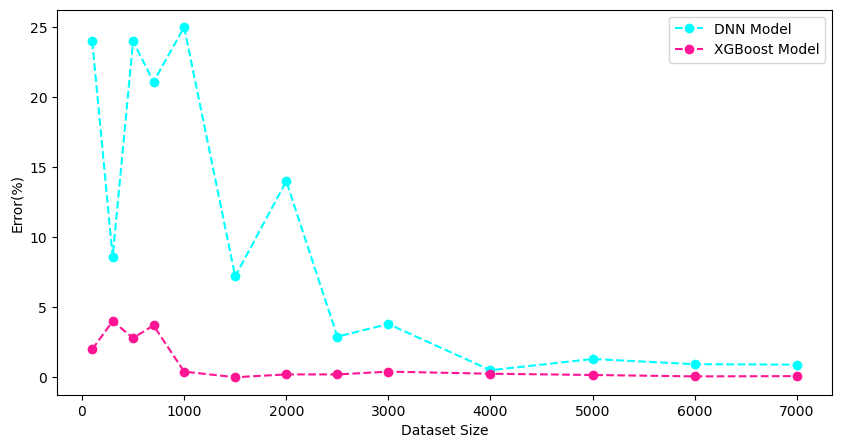

In [180]:
dataset_sizes = [100,300 ,500, 700, 1000 , 1500,2000,2500,3000, 4000, 5000 , 6000 , 7000 ]
DNN_errors = [24, 8.6 ,24, 21.1, 25,7.2,14, 2.9, 3.8 , 0.5, 1.3 ,0.93 ,0.9]
XGBoost_errors = [2, 4 , 2.8, 3.7, 0.4, 0, 0.2, 0.2, 0.4 , 0.25, 0.16 ,0.06 ,0.08]

fig, ax = plt.subplots(1 , 1 , figsize = (10 , 5))

ax.plot(dataset_sizes , DNN_errors , label = "DNN Model" , marker = 'o' , ls = '--' , mfc = 'cyan' , color = 'cyan')
ax.plot(dataset_sizes , XGBoost_errors  , label = "XGBoost Model", marker = 'o', ls = '--', mfc = 'deeppink', color = 'deeppink')
ax.set_xlabel('Dataset Size')
ax.set_ylabel('Error(%)')
ax.legend()

As you see, for smaller datasets, the error made by the DNN model is quite large compared to the XGBoost model. The gap between the two models decreases as the datasets become larger. So we can conclude that, the performance of DNNs is heavily dependent on the size of the dataset, while the error of XGBoost is small even for small datasets. 

### Task 2:

For this task we can use the parameters list which we created in the previous task in order to perform a gridsearch for the XGBoost model for a dataset of size 1000. 

In [321]:
lam=[100. ,90 , 80 , 70 , 60 , 50 , 40 ,30,20.,10.,5.,1.,0.5,0.1]
gam=[0.,1.,2.,4.,10.,20.,40.,100.,200.]
n_estimators = [10,20,30,40,50,60,70,80,90,100]
params = []

for l in lam:
    for g in gam:
        for n in n_estimators:
            
            #print("gamma:" , g , "lambda:" , l , "n:" , n)
            
            XGBoost_model = XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=l, n_estimators=n , gamma = g)
            
            XGBoost_fit = XGBoost_model.fit(x_train, y_train)
            err = 1 - XGBoost_model.score(x_test, y_test)
            params.append([l , g , n , err])

In [322]:
params = np.array(params)

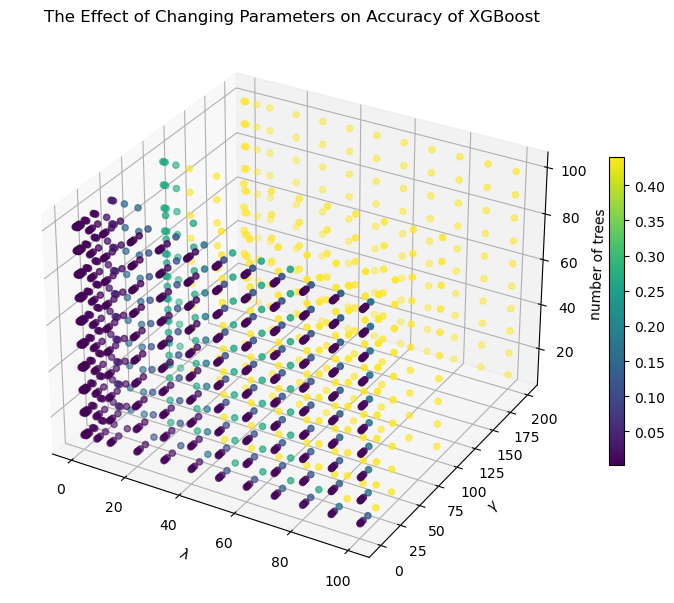

In [323]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (20 , 20))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
X = params[: , 0]
Y = params[: , 1]
Z = params[: , 2]
color = params[: , 3]


p = ax1.scatter(X, Y, Z, c=color , cmap = cm.viridis)
ax1.set_title('The Effect of Changing Parameters on Accuracy of XGBoost')
ax1.set_xlabel('$\lambda$')
ax1.set_ylabel('$\gamma$')
ax1.set_zlabel('number of trees')
cbar = fig.colorbar(p, ax=ax1 , shrink=0.2)

Above you can see a vizualiztion of the amount of errors(colorbar) against the parameters.   

In order to systematically choose the simplest yet effective model, we construct a dataframe for the different combinations of the parameters with their corresponding errors. Next we groupby each parameter and look at the mean values of the errors for each fixed value of a parameter.

In [326]:
import pandas as pd

df = pd.DataFrame(params , columns = ['Lambda' , 'Gamma','Number of Trees','Error'])
df

,Lambda,Gamma,Number of Trees,Error
0,100.0,0.0,10.0,0.008
1,100.0,0.0,20.0,0.008
2,100.0,0.0,30.0,0.008
3,100.0,0.0,40.0,0.008
4,100.0,0.0,50.0,0.008
...,...,...,...,...
1255,0.1,200.0,60.0,0.440
1256,0.1,200.0,70.0,0.440
1257,0.1,200.0,80.0,0.440
1258,0.1,200.0,90.0,0.440


We start with the parameter Gamma, which regulizes the number of the leafs within each tree:

In [328]:
df.groupby('Gamma').mean()

,Lambda,Number of Trees,Error
Gamma,,,
0.0,39.757143,55.0,0.005957
1.0,39.757143,55.0,0.006614
2.0,39.757143,55.0,0.007500
4.0,39.757143,55.0,0.008371
10.0,39.757143,55.0,0.061943
20.0,39.757143,55.0,0.183186
40.0,39.757143,55.0,0.288429
100.0,39.757143,55.0,0.390286
200.0,39.757143,55.0,0.440000


In [329]:
df.groupby('Gamma').std()

,Lambda,Number of Trees,Error
Gamma,,,
0.0,34.346347,28.825948,0.002676
1.0,34.346347,28.825948,0.002020
2.0,34.346347,28.825948,0.004634
4.0,34.346347,28.825948,0.005894
10.0,34.346347,28.825948,0.058775
20.0,34.346347,28.825948,0.162630
40.0,34.346347,28.825948,0.165848
100.0,34.346347,28.825948,0.078887
200.0,34.346347,28.825948,0.000000


As you see by varying the gamma parameter between 10 and 20, we get a large increase in the errors, while at gamma = 10, the error is quite low. So it is reasonable to fix gamma at 10 and look for the best values for the other parameters. 

Now we can creat a heatmap of the errors, for the different combinations of the values of the two remaining parameters 'Lambda' and 'Number of Trees' while we have fixed gamma = 10:

In [332]:
lam=np.sort(np.array([100. ,90 , 80 , 70 , 60 , 50 , 40 ,30,20.,10.,5.,1.,0.5,0.1]))
n_estimators = np.sort(np.array([10,20,30,40,50,60,70,80,90,100]))

error_matrix = np.zeros((len(lam) , len(n_estimators)))

In [333]:
for i,l in enumerate(lam):
        for j,n in enumerate(n_estimators):
            
            #print("gamma:" , g , "lambda:" , l , "n:" , n)
            XGBoost_model = XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=l, n_estimators=n , gamma = 10)
            
            XGBoost_fit = XGBoost_model.fit(x_train, y_train)
            err = 1 - XGBoost_model.score(x_test, y_test)
            error_matrix[i][j] = err 

In [342]:
import seaborn as sns

DF = pd.DataFrame(error_matrix, index = lam, columns = n_estimators )

Text(0.5, 20.049999999999997, 'number of trees')

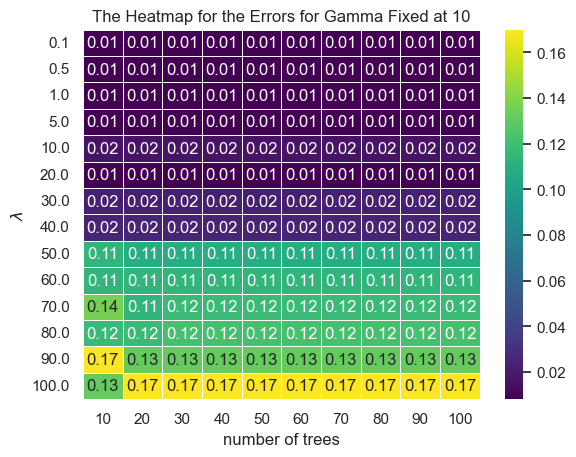

In [341]:
sns.set(font_scale=1)
ax = sns.heatmap(DF, cmap=cm.viridis, annot=True, linewidths=0.5, fmt=".2f")

ax.set_title("The Heatmap for the Errors for Gamma Fixed at 10")
ax.set_ylabel('$\lambda$')
ax.set_xlabel('number of trees')

From the heatmap above, we understand that for a choice of lambda greater than 40, the errors rise considerably, while by varying the number of trees at fixed lambda = 40, the error does not change. 

So we can conclude that the simplest yet the most effective model can be constructed by the following choice of parameters: Gamma = 10, Lambda = 40 and Number of Trees = 10

In [344]:
XGBoost_model = XGBClassifier(seed=1,
                       objective='binary:logistic',
                       #objective="reg:squarederror",eval_metric="rmse",
                       learning_rate=0.4,
                       reg_lambda=40, n_estimators=10 , gamma = 10)

XGBoost_fit = XGBoost_model.fit(x_train, y_train)
XGBoost_error = 1 - XGBoost_model.score(x_test, y_test)
print('error with the simplest yet effective model:' , XGBoost_error * 100 , '(%)')

error with the simplest yet effective model: 2.400000000000002 (%)
